# Using scCobra to integrate pancreas dataset

We need to import some packages, and specify the location of the R environment
If you use anaconda/miniconda, the location of the R environment usually ``~/.conda/envs/scCobra/lib/R``

In [1]:
import os
os.environ['R_HOME'] = "~/.conda/envs/scCobra/lib/R"

import warnings
warnings.filterwarnings("ignore")

import torch
import scanpy as sc

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from sccobra.preprocess import preprocess_adata
from sccobra.utils import make_dataloader
from sccobra.model import feature_encoder, discriminator
from sccobra.loss import InstanceLoss

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.2 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 louvain==0.7.1 pynndescent==0.5.7


## Read dataset and preprocess

In [2]:
adata = sc.read_h5ad('./data/human_pancreas_norm_complexBatch.h5ad')

You can preprocess your data using sccobra.preprocessing, pancreas dataset has been normalized and log1p transformed

In [3]:
adata = preprocess_adata(adata, batch_key='tech', normalize=False, log1p=False, scale=True, hvg=2000)

Using 65 HVGs from full intersect set
Using 221 HVGs from n_batch-1 set
Using 274 HVGs from n_batch-2 set
Using 269 HVGs from n_batch-3 set
Using 349 HVGs from n_batch-4 set
Using 435 HVGs from n_batch-5 set
Using 387 HVGs from n_batch-6 set
Using 2000 HVGs
--------------------------
Preprocessing is finished


## Define the dataloader

In [5]:
dataloader = make_dataloader(adata, batch_size=256)

## Define the model, loss function and optimizer

In [6]:
encoder_model = feature_encoder(adata.shape[1], adata.obs.domain_number[0])

dis_model = discriminator(256)
loss_fn = InstanceLoss(0.07)

optimizer_e = torch.optim.Adam(encoder_model.parameters(), lr=1e-3)
optimizer_e_a = torch.optim.Adam(encoder_model.parameters(), lr=3e-4)
optimizer_d = torch.optim.Adam(dis_model.parameters(), lr=1e-3)

## pretrain Contrastive Encoder with DSBN

In [7]:
import time
start = time.time()

for epoch in range(1, 31):
    encoder_model.train()
    sum_loss = 0
    for i, data in enumerate(dataloader):
        
        x = data[0].float()
        y = data[1].float()  
        
        optimizer_e.zero_grad()
        
        z, h1, h2 = encoder_model(x,y)

        loss_c = loss_fn(h1, h2)
        sum_loss += loss_c.item()
        
        loss_c.backward()
        optimizer_e.step()
        
    print(f'epoch:{epoch} | encoder_loss:{sum_loss/len(dataloader)}')
end = time.time()

print(f'pretrain use {end-start} seconds')

epoch:1 | encoder_loss:2.858611171207731
epoch:2 | encoder_loss:1.4213738782065255
epoch:3 | encoder_loss:1.0851895695640927
epoch:4 | encoder_loss:0.9406422263100034
epoch:5 | encoder_loss:0.8439788534527733
epoch:6 | encoder_loss:0.7660211712595016
epoch:7 | encoder_loss:0.7221068162766714
epoch:8 | encoder_loss:0.6780393029016162
epoch:9 | encoder_loss:0.6452485852771335
epoch:10 | encoder_loss:0.6265871127446493
epoch:11 | encoder_loss:0.604383006928459
epoch:12 | encoder_loss:0.576291717234112
epoch:13 | encoder_loss:0.5586791487913283
epoch:14 | encoder_loss:0.5465535303903004
epoch:15 | encoder_loss:0.5313558762981778
epoch:16 | encoder_loss:0.514867209252857
epoch:17 | encoder_loss:0.5047278588726407
epoch:18 | encoder_loss:0.5009106511161441
epoch:19 | encoder_loss:0.49286340011490715
epoch:20 | encoder_loss:0.4823791342122214
epoch:21 | encoder_loss:0.46842355245635625
epoch:22 | encoder_loss:0.4611542012010302
epoch:23 | encoder_loss:0.45736534822554814
epoch:24 | encoder_lo

## visualization of pretraining results

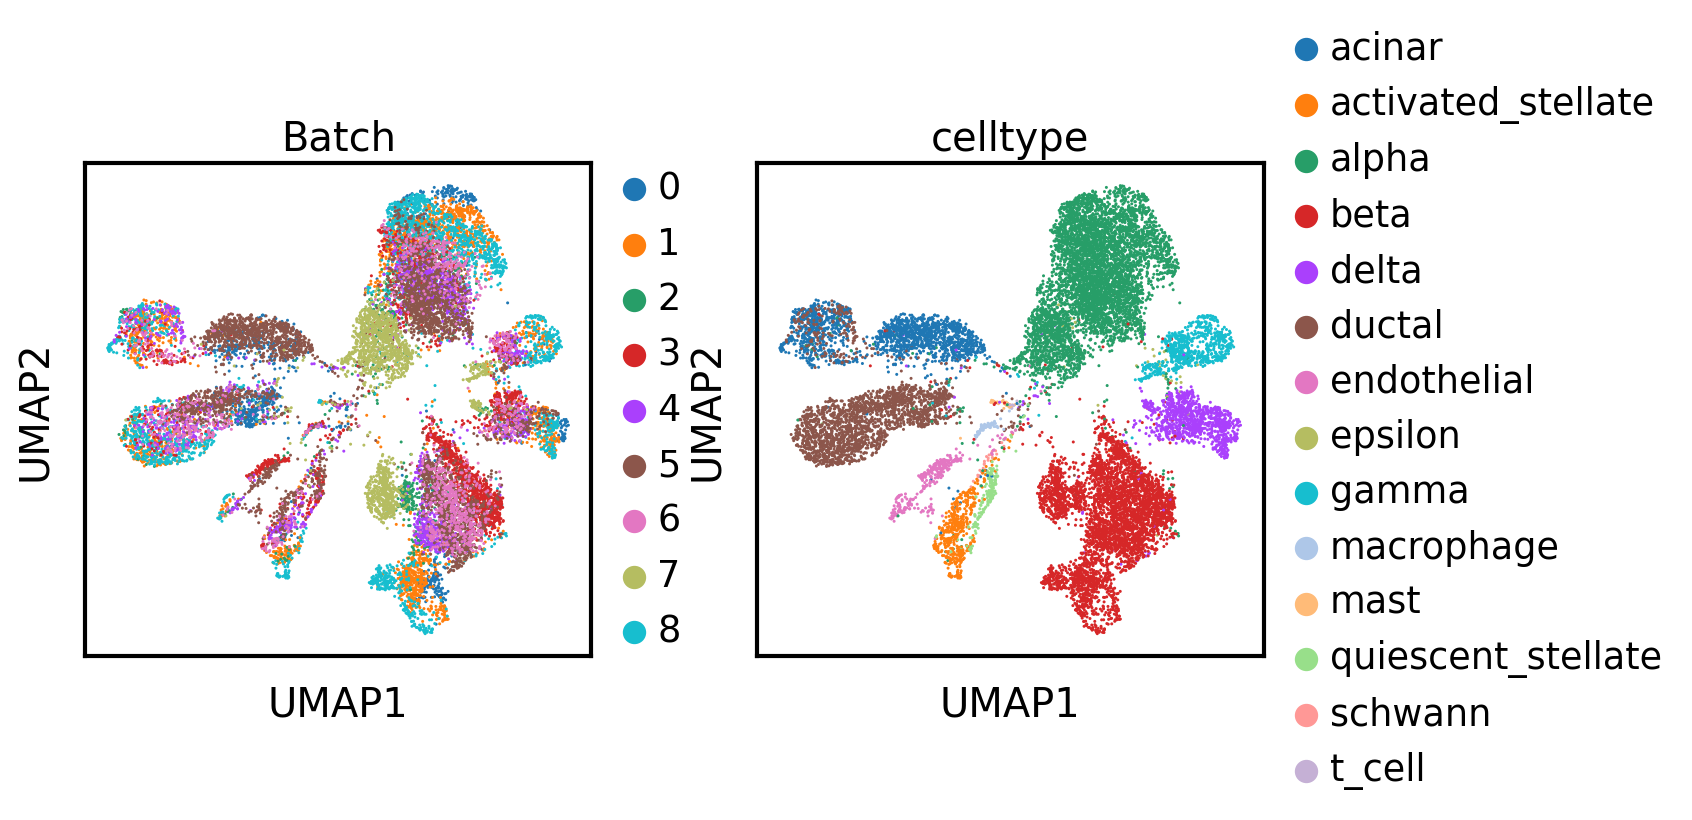

In [8]:
encoder_model.eval()
z, _, _ = encoder_model(torch.tensor(adata.X).float(), torch.tensor(adata.obs.label))
adata.obsm['X_emb'] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Batch','celltype'])

## Second step training

In the second step we add GAN to better integrate the pancreas dataset

In [9]:
start = time.time()

for epoch in range(1, 31):
    
    sum_c = 0
    sum_d = 0
    sum_e = 0
    
    for i, data in enumerate(dataloader):
        
        x = data[0].float()
        y = data[1].float()  
        
        #-------- train Discriminator----------------------
        encoder_model.eval()
        dis_model.train()
       
        for disc_iter in range(5):
            
            optimizer_d.zero_grad()
            
            z, h1, h2 = encoder_model(x,y)

            loss_d = dis_model(z,y)            

            sum_d += loss_d.item()

            loss_d.backward()
            optimizer_d.step()
                
        #-------- train Encoder----------------------------
        encoder_model.train()
        dis_model.eval()
        
        optimizer_e_a.zero_grad()
        
        z, h1, h2 = encoder_model(x,y)
        
        loss_d = dis_model(z,y)

        loss_c = loss_fn(h1, h2)
        
        loss_e = -loss_d * 0.5 + loss_c
        
        sum_e += loss_e.item()
        
        loss_e.backward()
        optimizer_e_a.step()
        
    print(f'epoch:{epoch} | encoder_loss:{sum_e/len(dataloader)}')

end = time.time()

print(f'Second step use {end-start} seconds')

epoch:1 | encoder_loss:-0.4280805162021092
epoch:2 | encoder_loss:-0.3531669463430132
epoch:3 | encoder_loss:-0.3658866962743184
epoch:4 | encoder_loss:-0.39187667719901553
epoch:5 | encoder_loss:-0.40425449657061746
epoch:6 | encoder_loss:-0.404680392571858
epoch:7 | encoder_loss:-0.4098804612008352
epoch:8 | encoder_loss:-0.4283110593992566
epoch:9 | encoder_loss:-0.4326931223982856
epoch:10 | encoder_loss:-0.4343559689938076
epoch:11 | encoder_loss:-0.4315466724690937
epoch:12 | encoder_loss:-0.47163289312332396
epoch:13 | encoder_loss:-0.46394593327764483
epoch:14 | encoder_loss:-0.4868027407025534
epoch:15 | encoder_loss:-0.48525201138995944
epoch:16 | encoder_loss:-0.5008282368145291
epoch:17 | encoder_loss:-0.5083444709815677
epoch:18 | encoder_loss:-0.5124181546862163
epoch:19 | encoder_loss:-0.5203433817341214
epoch:20 | encoder_loss:-0.5346073314311013
epoch:21 | encoder_loss:-0.539541346686227
epoch:22 | encoder_loss:-0.5375752037479764
epoch:23 | encoder_loss:-0.54346570987

## Second step training results

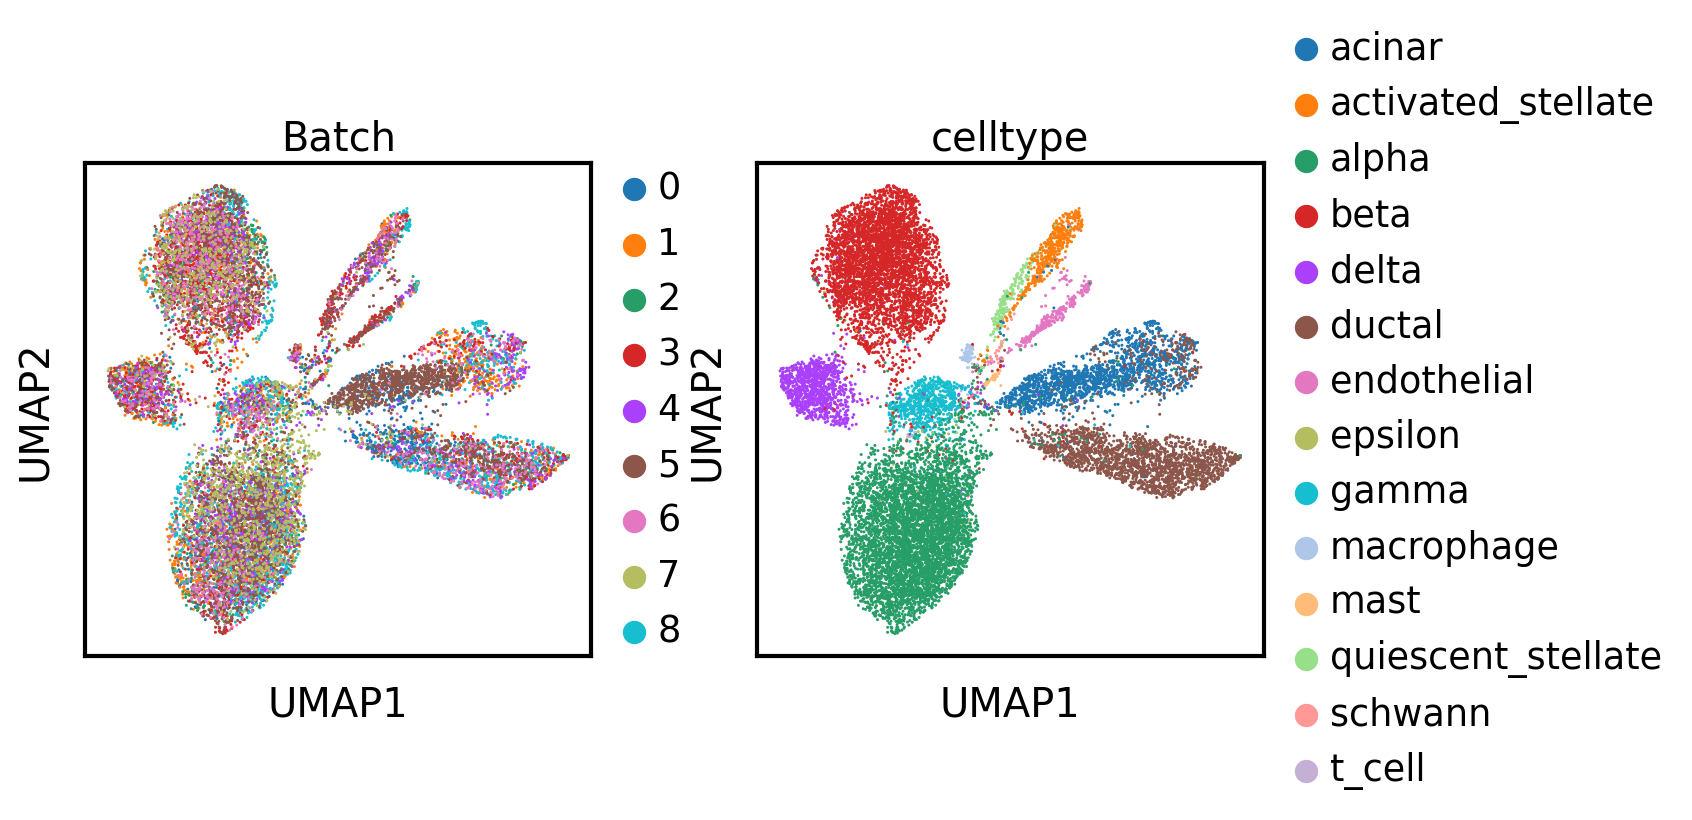

In [10]:
encoder_model.eval()
z, _, _ = encoder_model(torch.tensor(adata.X).float(), torch.tensor(adata.obs.label))
adata.obsm['X_emb'] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Batch','celltype'])